In [1]:
import os
import pandas as pd
from sklearn import model_selection, preprocessing
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
import string
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.model_selection import cross_val_score
from copy import deepcopy
from sklearn.metrics import plot_confusion_matrix
import tensorflow as tf
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.utils import Progbar

### Import function

In [2]:
from prepro import *
from co_sim import *

In [3]:
def countTotal(dataframes):
    count = 0
    for key in dataframes:
        count+=len(dataframes[key])
        print("{}:{}".format(key,len(dataframes[key])))
    print("total:{}".format(count))
    print("=============================================")

### Load Data Scraping Result

In [4]:
keyword = ['kecelakaan','tabrak']
site = ['detik','jatimnow','jawapos']
radar = ['radarmadura','radarbanyuwangi','radartulungagung','radarjember','radarsurabaya','radarjombang',
        'radarkediri','radarbojonegoro','radarmadiun','radarmalang','radarmojokerto','radarbromo',
         'radarsidoarjo','radargresik']
with_adv_search = ['radarbromo','radarsidoarjo','radarjember','radarmadiun','radarmalang','radargresik']

index='Link'
dataframes = {}

# Merge berita situs: detik, jatimnow, jawapos
for x in site:
    df_temp = []
    for y in keyword:
        df_temp.append(pd.read_csv("./INPUT/scraping result/{}_{}.csv".format(x,y),encoding='ISO-8859-1').iloc[:,1:])
    dataframes[x] = mergeData(df_temp[0],df_temp[1],index)

# Merge berita radar:
for x in radar:
    df_temp = []
    for y in keyword:
        df_temp.append(pd.read_csv("./INPUT/scraping result/googlenews_out/{}/{}_{}.csv".format(x,x,y),encoding='ISO-8859-1').iloc[:,1:])
    # Kalau situs radar punya advanced search
    if x in with_adv_search:
        df_temp2 = []
        for z in keyword:
            df_temp2.append(pd.read_csv("./INPUT/scraping result/adv search/{}_{}_.csv".format(x,z),encoding='ISO-8859-1').iloc[:,1:])
        dataframes[x] = mergeData(mergeData(df_temp[0],df_temp[1],index),
                                  mergeData(df_temp2[0],df_temp2[1],index),
                                  index)
    else:
        dataframes[x] = mergeData(df_temp[0],df_temp[1],index)

### Data Cleaning

In [5]:
dataframes = rmvMissCont(dataframes)
print("After Removing Missing Content:")
countTotal(dataframes)
dataframes = dropColumn(dataframes)
dataframes = convertDateTime(dataframes)
dataframes = filterDate(dataframes)
print("After Filtering Date Time:")
countTotal(dataframes)
dataframe = mergeDatas(dataframes)
print("After Merging Datas from all websites:")
len(dataframe)

After Removing Missing Content:
detik:510
jatimnow:314
jawapos:334
radarmadura:23
radarbanyuwangi:62
radartulungagung:46
radarjember:511
radarsurabaya:414
radarjombang:142
radarkediri:420
radarbojonegoro:30
radarmadiun:221
radarmalang:81
radarmojokerto:144
radarbromo:807
radarsidoarjo:79
radargresik:159
total:4297
After Filtering Date Time:
detik:510
jatimnow:314
jawapos:334
radarmadura:23
radarbanyuwangi:62
radartulungagung:46
radarjember:444
radarsurabaya:414
radarjombang:139
radarkediri:420
radarbojonegoro:30
radarmadiun:179
radarmalang:81
radarmojokerto:144
radarbromo:807
radarsidoarjo:79
radargresik:117
total:4143
After Merging Datas from all websites:


3855

# Hilangkan Berita yang Tidak Relevan dengan Naive Bayes Pseudo Label

In [6]:
# Load Labeled Data
data = deepcopy(dataframe)
data

,Link,Date Time,Title,Content
0,https://news.detik.com/berita-jawa-timur/d-531...,2020-12-31 14:51:00,"Ungkap Kasus Tabrak Lari, Polantas Sidoarjo Da...",Sidoarjo - Kinerja Sat Lantas Polresta Sidoarj...
1,https://news.detik.com/berita-jawa-timur/d-531...,2020-12-31 09:21:00,Ungkap Kasus Tabrak Lari Terbanyak Berbuah Pen...,Ponorogo - Kasus tabrak lari biasanya membutuh...
2,https://news.detik.com/berita-jawa-timur/d-531...,2020-12-30 18:24:00,Kasus Curat dan Penipuan Tertinggi di Tuban Se...,Tuban - Kasus kriminal di Tuban mengalami penu...
3,https://news.detik.com/berita-jawa-timur/d-531...,2020-12-30 12:19:00,Angka Kecelakaan Lalu Lintas di Lamongan Turun...,Lamongan - Angka kecelakaan lalu lintas di Lam...
4,https://news.detik.com/berita-jawa-timur/d-531...,2020-12-30 11:40:00,Puluhan Kasus Kriminal di Trenggalek Belum Ter...,Trenggalek - Polisi Trenggalek masih memiliki ...
...,...,...,...,...
3850,https://radargresik.jawapos.com/pojok-perkoro/...,2020-07-27 08:54:00,Penemuan Jenazah Bunuh Diri di Jembatan Sembayat,Gresik â Jenazah korban yang melompat dari a...
3851,https://radargresik.jawapos.com/politika/polit...,2020-07-24 09:19:00,PKB Resmi Copot Gus Yani,Gresik â Dewan Pengurus Pusat (DPP) PKB menc...
3852,https://radargresik.jawapos.com/pojok-perkoro/...,2020-07-24 08:58:00,Operasi Semeru 2020 Fokus Kurangi Laka,Gresik â Polres Gresik kembali menggelar ope...
3853,https://radargresik.jawapos.com/pojok-perkoro/...,2020-07-21 08:15:00,"Tabrakan Beruntun, Dua Pemotor Terluka",Gresik â Tabrakan beruntun terjadi di Jalan ...


Ambil beberapa data untuk diberi label secara manual

In [7]:
# SHUFFLE, TAKE RANDOM SAMPLE

# Shuffle data
data2 = data.iloc[:3738] # ambil 3738 data dari depan
datarand_idx = tf.random.shuffle(data2.index, seed=tf.random.set_seed(10)) # shuffle index
data_rand = data2.loc[datarand_idx,:] # get shuffled data

# Take 50% random sample for labeled data training and testing
labeled = data_rand.iloc[:round(0.5*len(data))] # get 50% data
unlabeled = data.loc[[x for x in data.index if x not in labeled.index]] # data sisanya

Setelah data diberi label secara manual, data diimpor kembali

In [8]:
# Impor data yang telah diberi label
labeled = pd.read_csv("./INPUT/data_to_label.csv", index_col=0)
labeled

,Link,Date Time,Title,Content,Label
2754,https://radarmadiun.jawapos.com/akibat-ditabra...,2020-03-04 19:29:00,"Akibat Ditabrak, Biaya Perbaikan Fasum Ditangg...","MAGETAN, Jawa Pos Radar Magetan ÃÂ¢ÃÂÃÂ T...",0.0
2529,https://radarkediri.jawapos.com/read/2020/06/1...,2020-06-15 14:15:11,"Pendaftaran Dibuka, Akses Website 24 Jam","NGANJUK, JP Radar Nganjuk- Pendaftaran tahap p...",0.0
2300,https://radarkediri.jawapos.com/read/2020/10/3...,2020-10-30 10:10:01,Siapkan 8 Pos Pantau Long Weekend\nAntisipasi ...,"NGANJUK, JP Radar NganjukÃ¢ÂÂ Mengantisipasi...",0.0
2248,https://radarkediri.jawapos.com/read/2020/11/2...,2020-11-21 14:55:33,"Kelola Air Merambat Putri Ayu, Jalin Kerja Sam...",Jumlah objek wisata yang dikelola oleh Disparp...,0.0
1634,https://radarjember.jawapos.com/berita-daerah/...,2020-04-23 02:11:00,\n,PEDULI: Komunitas Arek Kencong (KAK) tengah me...,0.0
...,...,...,...,...,...
13,https://news.detik.com/berita-jawa-timur/d-530...,2020-12-19 14:57:00,"Truk Kontainer Terguling di Lamongan, Lalu Lin...",Lamongan - Kecelakaan tunggal terjadi di Lamon...,1.0
1491,https://radarjember.jawapos.com/berita-daerah/...,2020-08-24 08:28:00,Petani Ujung Tombak Pembangunan Pertanian\n,APRESIASI UNTUK PETANI BERPRESTASI: Bupati Fai...,0.0
1368,https://radarjember.jawapos.com/berita-daerah/...,2020-11-03 10:03:00,"Rumah Kos Bebas Ini, Sudah Dua Kali Digrebek\n",DIDATANGI WARGA: Salah satu tempat kos yang ad...,0.0
3686,https://radarsidoarjo.jawapos.com/features/18/...,2020-11-18 19:23:00,Rawat Kucing Tak Sehat dengan Terapi Akupuntur,Aktivitas Pecinta Kucing Domestik Kucing di ja...,0.0


In [9]:
# Preprocess data: remove additional text, tags,word tokenization, remove stopwords, stem
articleProcessor =  PreProcessArticles()
labeled_pre = articleProcessor.processArticles(labeled)
unlabeled_pre = articleProcessor.processArticles(unlabeled)
labeled_pre

1928/1928 [==============================] - 42s 22ms/step
Finished.
1927/1927 [==============================] - 37s 19ms/step
Finished.


,Link,Date Time,Title,Content,Label
2754,https://radarmadiun.jawapos.com/akibat-ditabra...,2020-03-04 19:29:00,"Akibat Ditabrak, Biaya Perbaikan Fasum Ditangg...",magetan jawa pos radar magetan tunggu lampu li...,0.0
2529,https://radarkediri.jawapos.com/read/2020/06/1...,2020-06-15 14:15:11,"Pendaftaran Dibuka, Akses Website 24 Jam",nganjuk jp radar nganjuk- daftar tahap sma smk...,0.0
2300,https://radarkediri.jawapos.com/read/2020/10/3...,2020-10-30 10:10:01,Siapkan 8 Pos Pantau Long Weekend\nAntisipasi ...,nganjuk jp radar nganjuk antisipasi padat arus...,0.0
2248,https://radarkediri.jawapos.com/read/2020/11/2...,2020-11-21 14:55:33,"Kelola Air Merambat Putri Ayu, Jalin Kerja Sam...",objek wisata kelola disparporabud nganjuk tamb...,0.0
1634,https://radarjember.jawapos.com/berita-daerah/...,2020-04-23 02:11:00,\n,peduli komunitas arek kencong kak bagi paket m...,0.0
...,...,...,...,...,...
13,https://news.detik.com/berita-jawa-timur/d-530...,2020-12-19 14:57:00,"Truk Kontainer Terguling di Lamongan, Lalu Lin...",lamongan celaka tunggal lamongan truk kontaine...,1.0
1491,https://radarjember.jawapos.com/berita-daerah/...,2020-08-24 08:28:00,Petani Ujung Tombak Pembangunan Pertanian\n,apresiasi tani prestasi bupati faida piagam al...,0.0
1368,https://radarjember.jawapos.com/berita-daerah/...,2020-11-03 10:03:00,"Rumah Kos Bebas Ini, Sudah Dua Kali Digrebek\n",datang warga salah kos jawa asri lurah camat s...,0.0
3686,https://radarsidoarjo.jawapos.com/features/18/...,2020-11-18 19:23:00,Rawat Kucing Tak Sehat dengan Terapi Akupuntur,aktivitas cinta kucing domestik kucing jalan k...,0.0


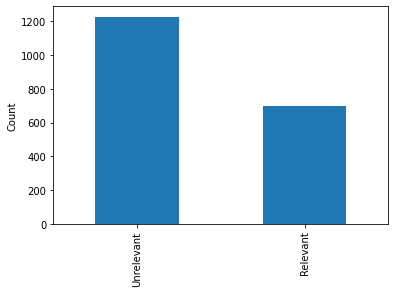

In [10]:
# Visualize class distribution
labeled_pre['Label'].value_counts().plot(kind='bar')
plt.xticks([0,1], ['Unrelevant', 'Relevant'])
plt.ylabel('Count');

## Algoritma CV Self Training Naive Bayes

Dijalankan k-fold pseudo label untuk mengukur performa model (bukan untuk membentuk model akhir)

In [11]:
# Declare X and Y
X = labeled_pre['Content']
y = labeled_pre['Label']

### K-Fold CV Self Training Naive Bayes

In [12]:
def kfold_pseudo_label(X,y,n_fold): # input: data berlabel X, data berlabel y, banyak fold yg diinginkan.
    
    # Split into n-fold
    kf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=10) # <-Proporsi split n
    
    # Array for storing evaluation models in each folds
    f1_train_li = []; acc_train_li = []; prec_train_li = [];rec_train_li = []
    f1_test_li = []; acc_test_li = []; prec_test_li = []; rec_test_li = []  
    fold = 0; progbar = Progbar(n_fold)

    # Iterate fold:
    print(f"Iterate {n_fold}-fold Pseudo Labeling:"); print("\n")
    for train_index, test_index in kf.split(X,y):
        # Split data -> train-test
        X_, X_test = X.iloc[train_index], X.iloc[test_index]
        y_, y_test = y.iloc[train_index], y.iloc[test_index]
    
        # Split train -> labeled-unlabeled
        random.seed(10)
        labeled_ind = random.sample(list(X_.index),round(0.2*len(X_))) # <-Proporsi 20% labeled, 80% unlabeled.
        
        #labeled (DIANGGAP SEBAGAI DATA TRAIN)
        X_train = X_.loc[labeled_ind]
        y_train = y_.loc[labeled_ind]   
        #unlabeled
        X_unlabeled = X_.loc[[True if x not in labeled_ind else False for x in list(X_.index)]]
        # y_unlabeled sebenarnya ada (utk keperluan kfold),
                                            # tapi dianggap tidak ada.
        
        high_prob = [1] # Assign value to initiate while loop
        pseudo_labels = []
        iterations = 0
    
        # Iteration pseudo-labeling
        while len(high_prob) > 0: # selama ada data yang probabilitasnya tinggi (melebihi threshold)

            print("iterations",iterations)
            # Set the vector transformer (from data train)
            columnTransformer = ColumnTransformer([
                ('tfidf',TfidfVectorizer(stop_words=None, max_features=100000),'Content')
            ],remainder='drop')
            vector_transformer = columnTransformer.fit(pd.DataFrame({'Content':X_train}))
            def transforms(series,vector_transformer=vector_transformer):
                before_vect = pd.DataFrame({'Content':series})
                return vector_transformer.transform(before_vect)
            
            # Transform data train, test dan unlabeled
            X_train_df = transforms(X_train);
            X_test_df = transforms(X_test);
            X_unlabeled_df = transforms(X_unlabeled)
        
            # Fit classifier and make test predictions
            nb = MultinomialNB()
            nb.fit(X_train_df, y_train)
            y_hat_train = nb.predict(X_train_df)
            y_hat_test = nb.predict(X_test_df)
            
            # Train
            f1_train = round(f1_score(y_train, y_hat_train),3)
            acc_train = round(accuracy_score(y_train, y_hat_train),3)
            prec_train = round(precision_score(y_train, y_hat_train),3)
            rec_train = round(recall_score(y_train, y_hat_train),3)
            
            # Test
            f1_test = round(f1_score(y_test, y_hat_test),3)
            acc_test = round(accuracy_score(y_test, y_hat_test),3)
            prec_test = round(precision_score(y_test, y_hat_test),3)
            rec_test = round(recall_score(y_test, y_hat_test),3)
            
            print("f1 train: ",f1_train)
            print("f1 test: ",f1_test)
            print("\n")
            
            pred_probs = nb.predict_proba(X_unlabeled_df)
            preds = nb.predict(X_unlabeled_df)
            prob_0 = pred_probs[:,0]
            prob_1 = pred_probs[:,1]

            # Store predictions and probabilities in dataframe
            df_pred_prob = pd.DataFrame([])
            df_pred_prob['preds'] = preds
            df_pred_prob['prob_0'] = prob_0
            df_pred_prob['prob_1'] = prob_1
            df_pred_prob.index = X_unlabeled.index
    
            # Separate predictions with > 75% probability
            high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.75], # <-threshold 0.75
                           df_pred_prob.loc[df_pred_prob['prob_1'] > 0.75]],
                          axis=0)
            pseudo_labels.append(len(high_prob))

            # Add pseudo-labeled data to training data
            X_train = pd.concat([X_train, X_unlabeled.loc[high_prob.index]], axis=0)
            y_train = pd.concat([y_train, high_prob.preds])      
            
            # Shuffle Train Data
            Xy_train_randind = tf.random.shuffle(X_train.index, seed=tf.random.set_seed(10))
            X_train = X_train.loc[Xy_train_randind]
            y_train = y_train.loc[Xy_train_randind] 
        
            # Drop pseudo-labeled instances from unlabeled data
            X_unlabeled = X_unlabeled.drop(index=high_prob.index)

            # Update iteration counter
            iterations += 1
            
        # Store evaluation model for fold-i
        f1_test_li.append(f1_test)
        acc_test_li.append(acc_test)
        prec_test_li.append(prec_test)
        rec_test_li.append(rec_test)
        
        f1_train_li.append(f1_train)
        acc_train_li.append(acc_train)
        prec_train_li.append(prec_train)
        rec_train_li.append(rec_train)
        
        # Fold increment
        fold+=1;
        progbar.update(fold)
        print("\n")
        #if fold==2: break
    print(f"Finished doing {n_fold}-fold CV.")
    
    # Return n_fold,f1,acc,prec,rec
    return [n_fold,f1_test_li,acc_test_li,prec_test_li,rec_test_li];

Print hasil

In [13]:
def mean(arr):
    return sum(arr)/len(arr)

def print_result_kfold_pseudo_label(results):
    for result in results:
        print(f"===== Result Pseudo-Labelling in {result[0]}-fold CV: =====\n")
        val = {"F1":result[1],"Accuracy":result[2],"Precison":result[3],"Recall":result[4]}
        for i in range(len(val)):
            print(f"{list(val)[i]}-scores\t:{val[list(val)[i]]}\nMean\t\t:{round(mean(val[list(val)[i]]),3)}\n")
        print("\n")

## Run K-Fold CV Self Training Naive Bayes

In [14]:
results = [] # var untuk menyimpan hasil pseudo-label

# Lakukan pseudo label
for n_fold in [5]:
    results.append(kfold_pseudo_label(X,y,n_fold))

Iterate 5-fold Pseudo Labeling:


iterations 0
f1 train:  0.98
f1 test:  0.957


iterations 1
f1 train:  0.994
f1 test:  0.964


iterations 2
f1 train:  0.994
f1 test:  0.961


iterations 3
f1 train:  0.994
f1 test:  0.961


1/5 [=====>........................] - ETA: 7s

iterations 0
f1 train:  0.996
f1 test:  0.929


iterations 1
f1 train:  0.991
f1 test:  0.94


iterations 2
f1 train:  0.993
f1 test:  0.94


iterations 3
f1 train:  0.993
f1 test:  0.94


iterations 4
f1 train:  0.993
f1 test:  0.943


iterations 5
f1 train:  0.993
f1 test:  0.943


iterations 6
f1 train:  0.993
f1 test:  0.943


iterations 7
f1 train:  0.993
f1 test:  0.943


iterations 8
f1 train:  0.993
f1 test:  0.939


iterations 9
f1 train:  0.993
f1 test:  0.939


2/5 [===========>..................] - ETA: 14s

iterations 0
f1 train:  0.974
f1 test:  0.923


iterations 1
f1 train:  0.991
f1 test:  0.933


iterations 2
f1 train:  0.991
f1 test:  0.94


iterations 3
f1 train:  0.991
f1 test:  0.936


iterations

In [15]:
# Print result
print_result_kfold_pseudo_label(results)

===== Result Pseudo-Labelling in 5-fold CV: =====

F1-scores	:[0.961, 0.939, 0.936, 0.961, 0.954]
Mean		:0.95

Accuracy-scores	:[0.972, 0.956, 0.953, 0.971, 0.966]
Mean		:0.964

Precison-scores	:[0.957, 0.942, 0.93, 0.964, 0.95]
Mean		:0.949

Recall-scores	:[0.964, 0.936, 0.943, 0.957, 0.957]
Mean		:0.951





## Model Akhir

Dari gabungan seluruh data train, lalu lakukan algoritma pseudo label untuk memprediksi seluruh data

In [16]:
X_final_train = deepcopy(labeled_pre['Content'])
y_final_train = deepcopy(labeled_pre['Label'])
X_final_unlabeled = deepcopy(unlabeled_pre['Content'])

Jalankan pseudo label (tanpa data test)

In [17]:
# Split train -> labeled-unlabeled
random.seed(10)
labeled_ind = random.sample(list(X_final_train.index),round(0.2*len(X_final_train))) # <-Proporsi 20% labeled, 80% unlabeled.

#labeled
X_train = X_final_train.loc[labeled_ind]
y_train = y_final_train.loc[labeled_ind]   

#unlabeled
X_unlabeled = X_final_train.loc[[True if x not in labeled_ind else False for x in list(X_final_train.index)]]

# Assign value to initiate while loop
high_prob = [1]
pseudo_labels = []
iterations = 0

# Iteration pseudo-labeling
while len(high_prob) > 0: # selama ada data yang probabilitasnya tinggi (melebihi threshold)

    # Set the vector transformer (from data train)
    print(f"Iteration {iterations+1}:")
    columnTransformer = ColumnTransformer([
        ('tfidf',TfidfVectorizer(stop_words=None, max_features=100000),'Content')
    ],remainder='drop')
    vector_transformer = columnTransformer.fit(pd.DataFrame({'Content':X_train}))
    def transforms(series,vector_transformer=vector_transformer):
        before_vect = pd.DataFrame({'Content':series})
        return vector_transformer.transform(before_vect)

    # Transform data: train and unlabeled
    X_train_df = transforms(X_train);
    X_unlabeled_df = transforms(X_unlabeled)

    # Fit classifier
    nb = MultinomialNB()
    nb.fit(X_train_df, y_train)

    # Generate predictions and probabilities for unlabeled data
    print(f"Now predicting labels for unlabeled data...")

    pred_probs = nb.predict_proba(X_unlabeled_df)
    preds = nb.predict(X_unlabeled_df)
    prob_0 = pred_probs[:,0]
    prob_1 = pred_probs[:,1]

    # Store predictions and probabilities in dataframe
    df_pred_prob = pd.DataFrame([])
    df_pred_prob['preds'] = preds
    df_pred_prob['prob_0'] = prob_0
    df_pred_prob['prob_1'] = prob_1
    df_pred_prob.index = X_unlabeled.index

    # Separate predictions with > 75% probability
    high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.75], # <-threshold 0.75
                    df_pred_prob.loc[df_pred_prob['prob_1'] > 0.75]],
                   axis=0)
    pseudo_labels.append(len(high_prob))
    print(f"{len(high_prob)} high-probability predictions added to training data.")

    # Add pseudo-labeled data to training data
    X_train = pd.concat([X_train, X_unlabeled.loc[high_prob.index]], axis=0)
    y_train = pd.concat([y_train, high_prob.preds])
    
    # Shuffle data Train
    Xy_train_randind = tf.random.shuffle(X_train.index, seed=tf.random.set_seed(10))
    X_train = X_train.loc[Xy_train_randind]
    y_train = y_train.loc[Xy_train_randind] 

    # Drop pseudo-labeled instances from unlabeled data
    X_unlabeled = X_unlabeled.drop(index=high_prob.index)

    print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")

    # Update iteration counter
    iterations += 1

Iteration 1:
Now predicting labels for unlabeled data...
1333 high-probability predictions added to training data.
209 unlabeled instances remaining.

Iteration 2:
Now predicting labels for unlabeled data...
120 high-probability predictions added to training data.
89 unlabeled instances remaining.

Iteration 3:
Now predicting labels for unlabeled data...
5 high-probability predictions added to training data.
84 unlabeled instances remaining.

Iteration 4:
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
83 unlabeled instances remaining.

Iteration 5:
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
83 unlabeled instances remaining.



Prediksi label seluruh data menggunakan model akhir

In [18]:
# Semua data
all_data = pd.concat([labeled,unlabeled])
all_data_pre = pd.concat([labeled_pre,unlabeled_pre])

# Transform
data_transformed = transforms(all_data_pre['Content'])

# Predict it!
predictions_final = nb.predict(data_transformed)
predictions_final

array([0., 0., 0., ..., 0., 1., 1.])

In [19]:
output = all_data_pre.iloc[:,:-1]
output['Label'] = predictions_final
output['Date Time'] = pd.to_datetime(dataframe['Date Time'])
output = output.sort_values(by=['Date Time'],ascending=False)
output

,Link,Date Time,Title,Content,Label
3659,https://radarsidoarjo.jawapos.com/kriminal-del...,2020-12-31 15:07:00,"Ban Slip di Jalan Raya Seduri, Tiga Orang Luka...",sidoarjo truk toyota dyna nopol l 8894 us laju...,1.0
3660,https://radarsidoarjo.jawapos.com/features/31/...,2020-12-31 15:01:00,Sukses Ungkap Kasus Tabrak Lari Pondok Tjandra,anggota polresta sidoarjo terima harga tabrak ...,0.0
0,https://news.detik.com/berita-jawa-timur/d-531...,2020-12-31 14:51:00,"Ungkap Kasus Tabrak Lari, Polantas Sidoarjo Da...",sidoarjo kerja sat lantas polresta sidoarjo ap...,0.0
1,https://news.detik.com/berita-jawa-timur/d-531...,2020-12-31 09:21:00,Ungkap Kasus Tabrak Lari Terbanyak Berbuah Pen...,ponorogo tabrak lari butuh ungkap terkadang un...,0.0
824,https://radarbromo.jawapos.com/probolinggo/30/...,2020-12-30 22:16:58,Istri yang Kecelakaan di Sumber Bersama Suami ...,sumber radar bromo- insiden celaka alami kelua...,1.0
...,...,...,...,...,...
823,https://jatimnow.com/baca-22640-mobil-wisatawa...,2020-01-01 17:07:15,Mobil Wisatawan asal Kulon Progo Tabrak Pohon ...,jatimnow com mobil toyota avanza alami celaka ...,1.0
508,https://news.detik.com/berita-jawa-timur/d-484...,2020-01-01 16:40:00,Braak! Mobil Rombongan Wisatawan Tabrak Pohon ...,pacitan braak mobil tabrak pohon unjung pantai...,1.0
509,https://news.detik.com/berita-jawa-timur/d-484...,2020-01-01 14:40:00,Korban Jiwa Akibat Kecelakaan di Bojonegoro Ti...,bojonegoro celaka lalu-lintas wilayah hukum po...,0.0
3031,https://radarmojokerto.jawapos.com/read/2020/0...,2020-01-01 13:00:59,Polisi Punya Tunggakan 93 Kasus,mojosari jawa pos radar mojokerto edar narkoba...,0.0


Ambil berita yang relevan saja

In [20]:
data_relevant = deepcopy(output.loc[output['Label']==1,:])
data_relevant_raw = deepcopy(data_relevant)
data_relevant_raw['Content'] = all_data['Content'].loc[data_relevant.index]

### Menghilangkan berita yang mirip

In [69]:
# Make dict for documents
docDict = {}
for i in data_relevant['Content'].index:
    docDict[i] = data_relevant['Content'][i]

# Calculate tfidf
tfidf = TfidfVectorizer(tokenizer=processData)
tfs = tfidf.fit_transform(docDict.values())
fileNames = data_relevant.index
cosim = dfCoSim(tfs, fileNames)

1408/1408 [==============================] - 1385s 984ms/step
Finished.


In [70]:
# Matrix nilai cosine tiap pasangan dokumen berita disimpan ke file .csv
cosim.to_csv("./OUTPUT/cosim.csv")

In [71]:
cosim = pd.read_csv("./OUTPUT/cosim.csv",index_col=0)
cosim.index = cosim.columns
cosim

,3659,824,2813,3033,1287,825,3046,3665,510,511,...,1694,506,821,3030,3658,3657,822,507,823,508
3659,1.000,0.101,0.060,0.177,0.029,0.060,0.093,0.198,0.107,0.104,...,0.052,0.047,0.046,0.074,0.157,0.116,0.048,0.067,0.123,0.065
824,0.101,1.000,0.026,0.108,0.015,0.101,0.789,0.095,0.089,0.059,...,0.074,0.074,0.059,0.069,0.093,0.104,0.066,0.074,0.078,0.021
2813,0.060,0.026,1.000,0.037,0.026,0.044,0.025,0.031,0.040,0.016,...,0.181,0.027,0.019,0.027,0.087,0.039,0.020,0.034,0.040,0.048
3033,0.177,0.108,0.037,1.000,0.020,0.206,0.102,0.141,0.140,0.102,...,0.088,0.056,0.072,0.061,0.062,0.208,0.096,0.126,0.042,0.097
1287,0.029,0.015,0.026,0.020,1.000,0.036,0.011,0.029,0.019,0.015,...,0.023,0.003,0.211,0.031,0.058,0.062,0.034,0.046,0.034,0.056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3657,0.116,0.104,0.039,0.208,0.062,0.087,0.103,0.113,0.081,0.102,...,0.045,0.338,0.059,0.041,0.159,1.000,0.089,0.102,0.077,0.055
822,0.048,0.066,0.020,0.096,0.034,0.065,0.069,0.078,0.094,0.039,...,0.064,0.052,0.056,0.057,0.067,0.089,1.000,0.714,0.057,0.065
507,0.067,0.074,0.034,0.126,0.046,0.115,0.079,0.108,0.117,0.051,...,0.092,0.081,0.054,0.078,0.083,0.102,0.714,1.000,0.082,0.076
823,0.123,0.078,0.040,0.042,0.034,0.035,0.074,0.033,0.041,0.158,...,0.007,0.021,0.044,0.077,0.216,0.077,0.057,0.082,1.000,0.336


Buang data yang mirip (nilai cosine > 0.6)

In [72]:
threshold = 0.6
remove_sim = remove_similar(data_relevant_raw, cosim, threshold)

Data Akhir (ada 1247 berita):

In [73]:
remove_sim[2]

,Link,Date Time,Title,Content,Label
3659,https://radarsidoarjo.jawapos.com/kriminal-del...,2020-12-31 15:07:00,"Ban Slip di Jalan Raya Seduri, Tiga Orang Luka...",SIDOARJO ÃÂ¢ÃÂÃÂ Sebuah truk Toyota Dyna ...,1.0
2813,https://radarmalang.jawapos.com/malang-raya/ko...,2020-12-30 02:56:00,"Diduga Melamun, Angkot Masuk Sungai di Arjosari",MALANG KOTA ÃÂ¢ÃÂÃÂ Mungkin hari ini (30/...,1.0
3033,https://radarbromo.jawapos.com/kraksaan/30/12/...,2020-12-30 00:00:00,"Menyeberang, Tukang Becak Tewas Tertabrak Truk...","KRAKSAAN, Radar Bromo Ã¢ÂÂNahas menimpa Misk...",1.0
1287,https://radarjember.jawapos.com/berita-daerah/...,2020-12-29 14:10:00,"Waduh, kok Bisa Menerobos?\n",TEROBOS LINTASAN: Sebuah mobil Isuzu Panther b...,1.0
825,https://radarbromo.jawapos.com/kraksaan/29/12/...,2020-12-29 08:45:36,11 Bulan Ada 488 Kecelakaan yang Tewaskan 65 N...,"KRAKSAAN, Radar Bromo ÃÂ¢ÃÂÃÂ Jumlah insi...",1.0
...,...,...,...,...,...
3658,https://radarbromo.jawapos.com/headlines/02/01...,2020-01-02 00:00:00,"Pulang Liburan dari Bali, Fortuner yang Ditump...","PASURUAN, Radar Bromo Ã¢ÂÂ Agenda liburan ro...",1.0
3657,https://radarbromo.jawapos.com/headlines/02/01...,2020-01-02 00:00:00,Satu Keluarga asal Blitar Kecelakaan di Tol Ge...,"GEMPOL, Radar BromoÃ¢ÂÂ Nahas nian nasib yan...",1.0
507,https://news.detik.com/berita-jawa-timur/d-484...,2020-01-01 17:15:00,MPV Hantam Motor dan Terbalik di Jalur Blitar-...,Blitar - Kecelakaan lalu lintas melibatkan seb...,1.0
823,https://jatimnow.com/baca-22640-mobil-wisatawa...,2020-01-01 17:07:15,Mobil Wisatawan asal Kulon Progo Tabrak Pohon ...,jatimnow.com - Sebuah mobil Toyota Avanza meng...,1.0


Ini adalah kelompok data yang mirip

In [74]:
remove_sim[0]

[{0},
 {1, 6},
 {2},
 {3},
 {4},
 {5},
 {7},
 {8},
 {9},
 {10},
 {11},
 {12},
 {13},
 {14},
 {15},
 {16},
 {17},
 {18},
 {19},
 {20},
 {21},
 {22},
 {23},
 {24},
 {25},
 {26},
 {27},
 {28},
 {29},
 {30},
 {31},
 {32},
 {33},
 {34},
 {35},
 {36},
 {37},
 {38},
 {39},
 {40},
 {41},
 {42},
 {43, 49, 56, 57},
 {44},
 {45},
 {46},
 {47, 50},
 {48},
 {51},
 {52},
 {53},
 {54},
 {55},
 {58},
 {59},
 {60},
 {61},
 {62},
 {63},
 {64},
 {65},
 {66},
 {67},
 {68},
 {69},
 {70},
 {71},
 {72},
 {73},
 {74},
 {75},
 {76},
 {77},
 {78},
 {79},
 {80, 81},
 {82},
 {83},
 {84},
 {85},
 {86},
 {87},
 {88},
 {89},
 {90},
 {91},
 {92},
 {93},
 {94},
 {95},
 {96},
 {97},
 {98},
 {99},
 {100},
 {101},
 {102},
 {103},
 {104},
 {105},
 {106, 113},
 {107},
 {108, 112},
 {109, 114},
 {110},
 {111, 116, 120, 121, 123, 124, 125, 127, 129},
 {115},
 {117},
 {118},
 {119},
 {122},
 {126, 131},
 {128},
 {130},
 {132},
 {133},
 {134},
 {135},
 {136},
 {137},
 {138},
 {139},
 {140},
 {141},
 {142},
 {143},
 {144},
 {14

Contoh isi content dari pasangan berita yang mirip:

In [78]:
data_relevant_raw.iloc[56]['Content']

'Pasuruan - Kecelakaan maut antara truk dan dua motor terjadi di Jalan Raya Bromo, Desa Karang Sentul Kecamayan Gondang Wetan Kabupaten Pasuruan. Kecelakan ini merenggut tiga nyawa.\nPeristiwa ini terjadi Selasa (15/12/2020) pukul 13.10 WIB saat hujan lebat. Kecelakaan bermula saat truk nopol P 8986 UK yang dikemudikan Antok Sudrajad (22) warga Desa Panditan, Lumbang, Pasuruan berjalan dari arah utara ke selatan.\nSampai di lokasi truk mengalami selip. Truk kemudian oleng ke kanan sehingga menabrak pengendara motor Suzuki Shogun bernopol N 6367 XK dan Honda Supra X bernopol W 3556 YR dari arah berlawanan.\nBaca juga:\nMotor Roda Tiga Terjun ke Jurang di Pasuruan, Pengendaranya Tewas\nFoto: Muhajir Arifin\n"Truk mengalami selip karena hujan deras dan oleng ke kanan sehingga menabrak dua motor dari arah berlawanan. Satu motor berboncengan sedangkan motor kedua sendirian," kata Kasat Lantas Polres Pasuruan Kota AKP Yudiyono, Selasa (15/12/2020).\nSetelah menabrak dua motor, truk terus mel

In [77]:
data_relevant_raw.iloc[57]['Content']

'jatimnow.com - Sebuah truk bernopol P 8986 UK menabrak dua motor dengan nopol W 3556 YR dan N 6367 XK di Jalan Raya Gunung Bromo, Desa Karangsentul, Kecamatan Gondangwetan, Kabupaten Pasuruan, sekitar pukul 14.00 Wib, Selasa (15/12/2020).\nSopir truk tersebut diketahui bernama Antok, warga Kecamatan Lumbang, Kabupaten Pasuruan.\n"Kecelakaan ini mengakibatkan tiga orang meninggal dunia. Satu berboncengan, satu mengendarai motor sendiri. Untuk identitas korban masih dalam pendataan petugas. Jenazah sudah kami evakuasi ke ruang jenazah RSUD R Soedarsono," jelas Kasatlantas Polres Pasuruan Kota, AKP Yudiyono.\nYudiyono menyebut, dari pemeriksaan sopir truk dan para saksi di TKP, truk itu melaju dari selatan menuju utara. Kondisi jalanan aspal yang licin akibat hujan membuat sopir tidak bisa menguasai laju truknya.\nSaat sampai di TKP, truk tersebut selip dan oleng masuk ke jalur berlawanan hingga menabrak dua motor yang ditumpangi para korban.\n"Sopir truk tidak bisa menguasai laju kendar

Hasil data yg bebas dari duplikasi disimpan ke file .csv:

In [79]:
remove_sim[2].to_csv("./OUTPUT/PRE_CLEAN_FIX.csv")